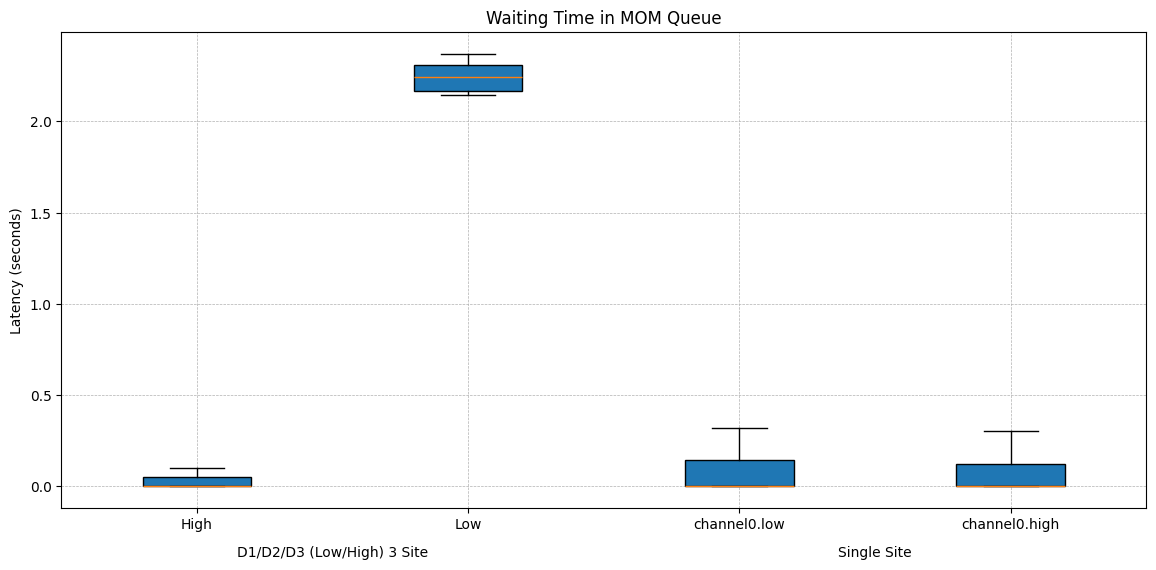

In [23]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_latency_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines:
        match = re.search(r'Latency in (\S+): ([\d.]+) seconds', line)
        if match:
            channel = match.group(1)
            latency = float(match.group(2))
            data.append({'channel': channel, 'latency': latency})
    return pd.DataFrame(data)

dispatcher_files = [
    '../3Site/latency_metrics_dispatcher_1.txt',
    '../3Site/latency_metrics_dispatcher_2.txt',
    '../3Site/latency_metrics_dispatcher_3.txt'
]

channel_file = '../1Site/latency_metrics_dispatcher_1.txt'

low_latencies = []
high_latencies = []

for file in dispatcher_files:
    df = parse_latency_file(file)
    low_latencies.extend(df[df['latency'] <= 0.5]['latency'].values)
    high_latencies.extend(df[df['latency'] > 0.5]['latency'].values)

channel_df = parse_latency_file(channel_file)
channel_names = channel_df['channel'].unique()
channel_data = [
    channel_df[channel_df['channel'] == ch]['latency'].values
    for ch in channel_names
]

box_data = [low_latencies, high_latencies] + channel_data
labels = ['High', 'Low'] + list(channel_names)  # swapped labels only

fig, ax = plt.subplots(figsize=(14, 7))

ax.boxplot(box_data, tick_labels=labels, showfliers=False, patch_artist=True, widths=0.4)

xticks = np.arange(1, len(labels) + 1)
ylim = ax.get_ylim()
y_pos = ylim[0] - (ylim[1] - ylim[0]) * 0.08  # Position below x-axis labels

# Add second-level labels grouped
# Under first two boxes:
mid_pos_first = np.mean(xticks[0:2])
ax.text(mid_pos_first, y_pos, 'D1/D2/D3 (Low/High) 3 Site', ha='center', va='top', fontsize=10)

# Under last boxes (channels):
mid_pos_last = np.mean(xticks[2:])
ax.text(mid_pos_last, y_pos, 'Single Site', ha='center', va='top', fontsize=10)

plt.subplots_adjust(bottom=0.2)

ax.set_title("Waiting Time in MOM Queue")
ax.set_xlabel("")
ax.set_ylabel("Latency (seconds)")
ax.grid(True, linestyle='--', linewidth=0.5)
plt.savefig("WaitingTimeMOM.png", dpi=300, bbox_inches='tight')

plt.show()



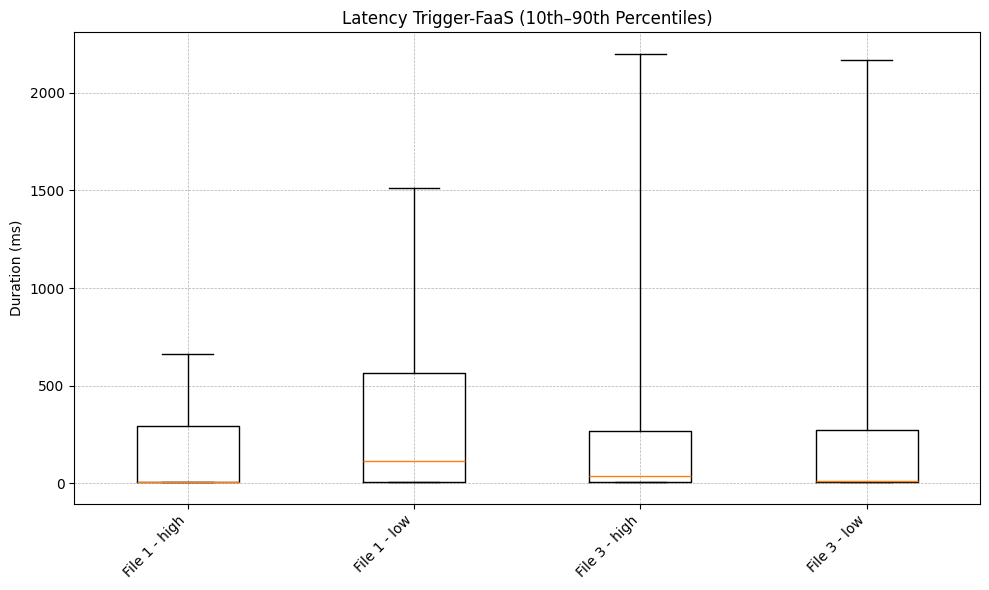

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Map for label swap
label_map = {"high": "low", "low": "high", "unknown": "unknown"}

# Function to extract trace timings from a file
def extract_trace_data(filename, source_label):
    with open(filename) as f:
        trace_data = json.load(f)

    trace_timings = []
    for trace in trace_data["data"]:
        trace_id = trace["traceID"]
        start_times = []
        end_times = []
        trigger_level = None

        for span in trace["spans"]:
            start = span["startTime"]
            duration = span["duration"]
            end = start + duration
            start_times.append(start)
            end_times.append(end)

            for tag in span.get("tags", []):
                if tag["key"] == "trigger.level":
                    trigger_level = tag["value"]

        if start_times and end_times:
            total_duration_us = max(end_times) - min(start_times)
            total_duration_ms = total_duration_us / 1000
            trace_timings.append({
                "trace_id": trace_id,
                "duration_ms": total_duration_ms,
                "trigger_level": trigger_level or "unknown",
                "source": source_label
            })

    return pd.DataFrame(trace_timings)

# Extract data from both files
df1 = extract_trace_data("../1Site/traces-1753434179515.json", "File 1")
df2 = extract_trace_data("../3Site/traces-1753433183127.json", "File 3")

# Combine them
df = pd.concat([df1, df2], ignore_index=True)

# Apply label mapping
df["mapped_trigger_level"] = df["trigger_level"].map(label_map).fillna("unknown")

# Create a new column for group labels (source + trigger level)
df["group"] = df["source"] + " - " + df["mapped_trigger_level"]

# Prepare boxplot data (10th to 90th percentiles)
box_data = []
for group in sorted(df["group"].unique()):
    durations = df[df["group"] == group]["duration_ms"].values
    if len(durations) == 0:
        continue
    stats = {
        'label': group,
        'whislo': np.percentile(durations, 10),
        'q1':     np.percentile(durations, 25),
        'med':    np.percentile(durations, 50),
        'q3':     np.percentile(durations, 75),
        'whishi': np.percentile(durations, 90),
        'fliers': []
    }
    box_data.append(stats)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bxp(box_data, showfliers=False)

ax.set_title("Latency Trigger-FaaS (10th–90th Percentiles)")
ax.set_ylabel("Duration (ms)")
ax.set_xticklabels([bd["label"] for bd in box_data], rotation=45, ha="right")
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("LatencyTrigger-Faas", dpi=300, bbox_inches='tight')

plt.show()
